# **CHEM E 545 Final Project**
## **Predicting Catalyst Deactivation using Multi-Layer Perceptron** <br>
In this final project, you will develop a multi-layer perceptron (MLP) neural network using scikit-learn as well as your own customized deep learning model using tensorflow to predict catalyst deactivation in chemical processes. Catalysts are essential in many chemical engineering operations, but they can lose effectiveness over time due to various mechanisms including poisoning, fouling, sintering, and thermal degradation. Predicting when a catalyst will deactivate is crucial for scheduling maintenance and optimizing process economics.
You have been provided with a .csv file with some attributes about the catalyst and a deactivation state.  Do data preprocessing if necessary at any step, always use a random seed wherever you can and describe your methods and results in detail. All plots should have labels and legends. 
Complete the tasks below (80 points):

In [58]:
# Import necessary libraries

# Data Handling and Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Dimensionality Reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Evaluation and Validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.neural_network import MLPClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Tensor Flow
import tensorflow as tf
from tensorflow.keras.models import Sequential, Dense



ModuleNotFoundError: No module named 'tensorflow'

### **1. Data Preprocessing**
check for the presence of categorial variables, decide how will you handle it, handle any missing values and visualize the class distribution.  Split the data into training and testing sets using stratified sampling (used when there are class imbalances) and preprocess your data using standard scaler ( note: categorial features are not processed using standard scaler) (10 points).

In [11]:
# Load the CSV file into a DataFrame
df = pd.read_csv('catalyst_data.csv')

# Display the first few rows of the DataFrame to verify
print(df.head())

   Temperature   Pressure      WHSV  Feed_Impurity  Residence_Time  \
0   312.362036  10.071514  2.986204       3.363515        2.902780   
1   485.214292  27.553146  2.846299       3.983407        4.046618   
2   419.598183  43.774346  9.109419       1.252339        3.824789   
3   379.597545  36.879019  2.870689       3.124370        0.854110   
4   246.805592  40.521496  3.083522       2.858730        0.831322   

  Catalyst_Type  Catalyst_Age  Surface_Area  Pore_Volume  Active_Sites  \
0   Noble Metal    628.347118    336.941412     1.356101      4.461899   
1   Noble Metal    184.101323    557.827052     0.269051      2.451757   
2   Noble Metal    105.650345    453.482966     1.318636      2.354421   
3   Metal Oxide    812.850972    377.375009     1.600180      0.660255   
4   Noble Metal    578.756476    697.161703     1.100645      2.740893   

   Regeneration_Cycles Operation_Mode Reactor_Type  Deactivated  
0                    1          Batch    Fixed Bed        False  
1 

In [12]:
# Step 1.1: Check for categorical variables
print("Categorical Variables:")
print(df.select_dtypes(include=['object', 'bool']).columns)

# Step 1.2: Handle categorical variables
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=["Catalyst_Type", "Operation_Mode", "Reactor_Type"], drop_first=True)

# Map 'Deactivated' to binary (True -> 1, False -> 0)
df["Deactivated"] = df["Deactivated"].astype(int)


Categorical Variables:
Index(['Catalyst_Type', 'Operation_Mode', 'Reactor_Type', 'Deactivated'], dtype='object')


In [13]:
# Step 1.3: Handle missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Temperature                   0
Pressure                      0
WHSV                          0
Feed_Impurity                 0
Residence_Time                0
Catalyst_Age                  0
Surface_Area                  0
Pore_Volume                   0
Active_Sites                  0
Regeneration_Cycles           0
Deactivated                   0
Catalyst_Type_Noble Metal     0
Catalyst_Type_Zeolite         0
Operation_Mode_Continuous     0
Operation_Mode_Semi-batch     0
Reactor_Type_Fluidized Bed    0
Reactor_Type_Trickle Bed      0
dtype: int64


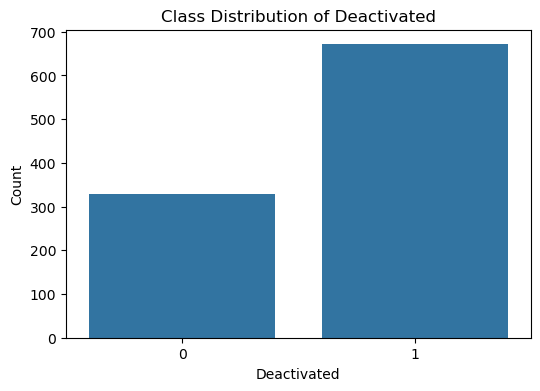

In [14]:
# Step 1.4: Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Deactivated", data=df)
plt.title("Class Distribution of Deactivated")
plt.xlabel("Deactivated")
plt.ylabel("Count")
plt.show()

In [15]:
# Step 1.5: Split the data into training and testing sets using stratified sampling
X = df.drop("Deactivated", axis=1)  # Features
y = df["Deactivated"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
# Step 1.6: Preprocess data using StandardScaler (only for numerical features)
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

### **2. Data Visualization and Unsupervised Classification**
Visualize the data and implement PCA (justify the choice of the optimal number of components) and K-means to see if you can separate different states. Finally, try doing K-means to see if you get better clustering. Report your findings. (10)

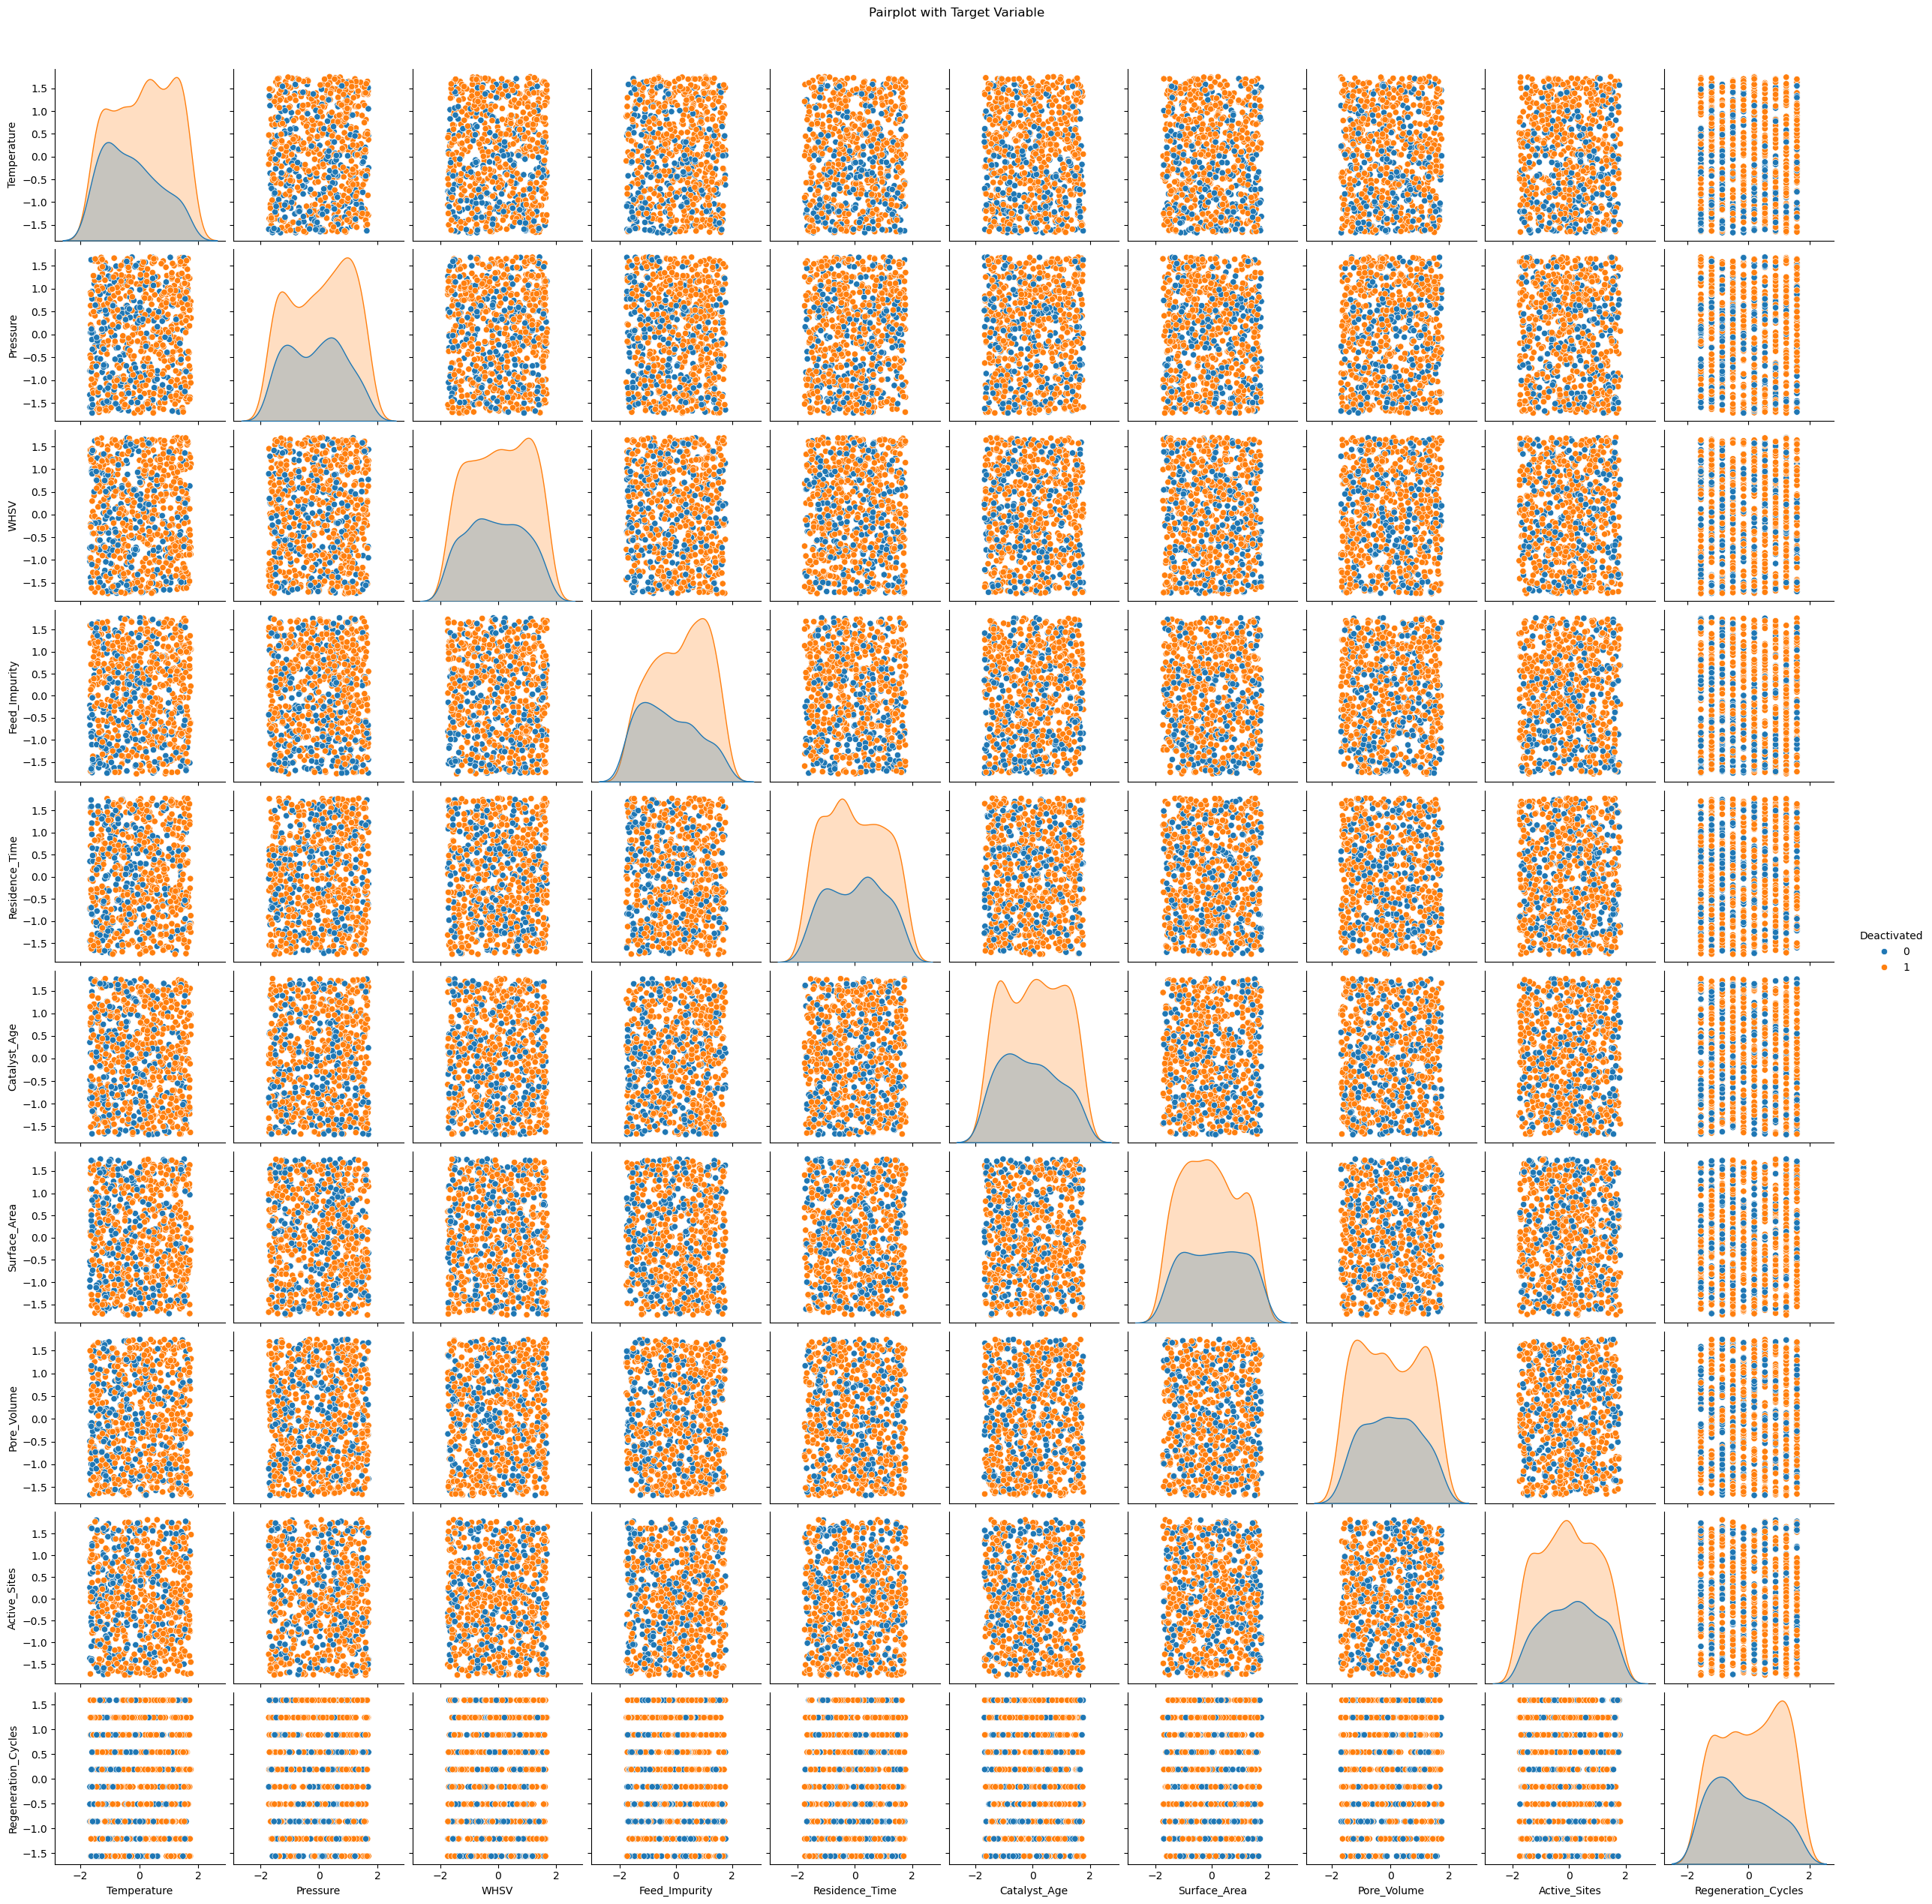

In [20]:
# Add the target variable to the DataFrame
X_train_with_target = X_train.copy()
X_train_with_target["Deactivated"] = y_train

# Create a pairplot with the target variable
sns.pairplot(X_train_with_target, hue="Deactivated", vars=numerical_features)
plt.suptitle("Pairplot with Target Variable", y=1.02)
plt.show()

### PCA

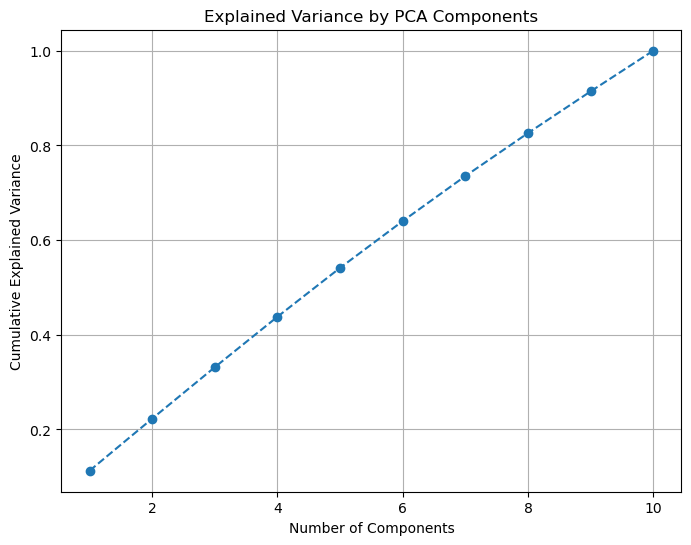

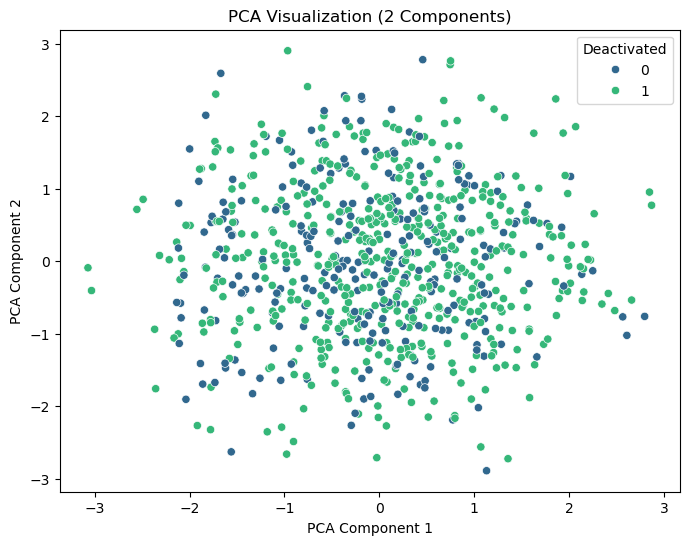

PCA Loadings (Contributions of Original Features to PC1 and PC2):
     Temperature  Pressure      WHSV  Feed_Impurity  Residence_Time  \
PC1     0.493602  0.596630  0.121885      -0.264928        0.454148   
PC2    -0.148100 -0.054722 -0.092863      -0.280460        0.147061   

     Catalyst_Age  Surface_Area  Pore_Volume  Active_Sites  \
PC1     -0.084289     -0.256349     0.099263     -0.162411   
PC2      0.175700      0.380803    -0.029212     -0.535523   

     Regeneration_Cycles  
PC1             0.006829  
PC2             0.634542  


In [30]:
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_train[numerical_features])

# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# Choose the optimal number of components (e.g., 2 for visualization)
optimal_components = 2
pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X_train[numerical_features])

# Visualize PCA components
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis')
plt.title(f"PCA Visualization (2 Components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Deactivated")
plt.show()


# Get the PCA loadings (components_ attribute)
pca_loadings = pca.components_

# Create a DataFrame to show the contribution of each original feature to the PCA components
loadings_df = pd.DataFrame(pca_loadings, columns=numerical_features, index=['PC1', 'PC2'])

# Display the loadings
print("PCA Loadings (Contributions of Original Features to PC1 and PC2):")
print(loadings_df)

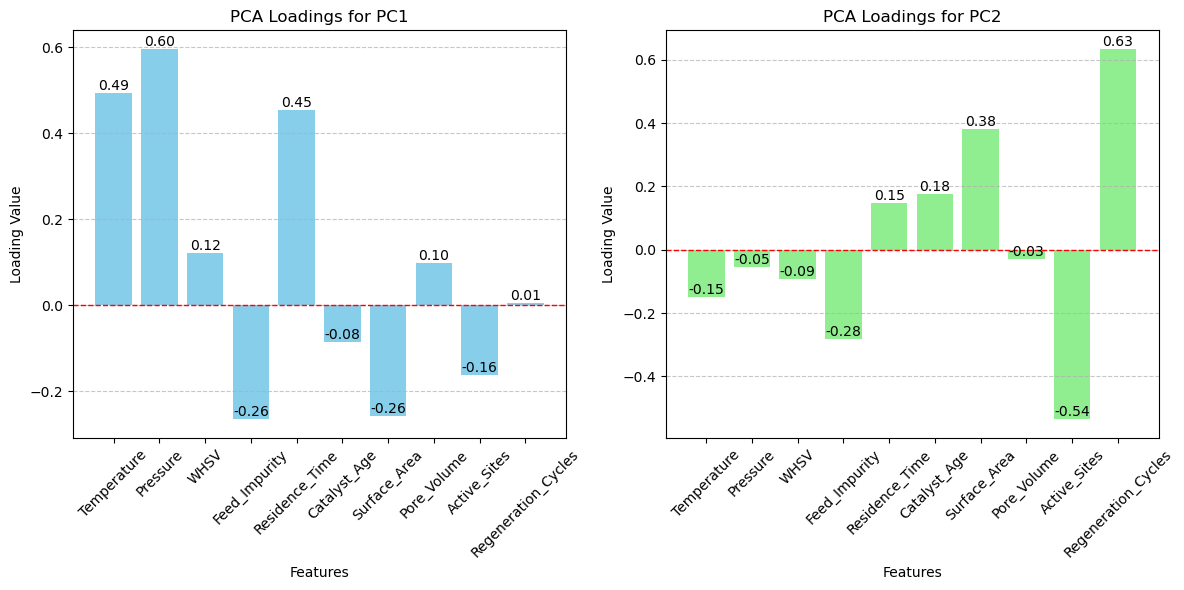

In [31]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Plot the loadings for PC1
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
bars = plt.bar(loadings_df.columns, loadings_df.loc['PC1'], color='skyblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a reference line at 0
plt.title("PCA Loadings for PC1")
plt.xlabel("Features")
plt.ylabel("Loading Value")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Plot the loadings for PC2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
bars = plt.bar(loadings_df.columns, loadings_df.loc['PC2'], color='lightgreen')
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add a reference line at 0
plt.title("PCA Loadings for PC2")
plt.xlabel("Features")
plt.ylabel("Loading Value")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

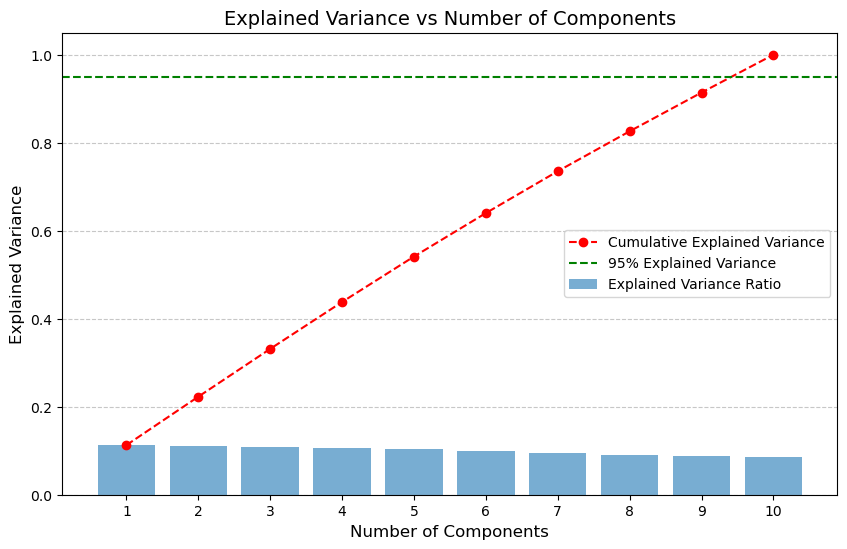

Optimal number of components to explain 95% of the variance: 10


In [33]:
# Perform PCA with all possible components
pca = PCA()
pca.fit(X_train[numerical_features])

# Calculate explained variance ratio and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance ratio and cumulative explained variance
plt.figure(figsize=(10, 6))

# Plot explained variance ratio
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Explained Variance Ratio')

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='red', label='Cumulative Explained Variance')

# Add labels, title, and legend
plt.title("Explained Variance vs Number of Components", fontsize=14)
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("Explained Variance", fontsize=12)
plt.xticks(range(1, len(cumulative_explained_variance) + 1))
plt.axhline(y=0.95, color='green', linestyle='--', label='95% Explained Variance')  # Threshold line
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print the number of components required to explain 95% of the variance
optimal_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Optimal number of components to explain 95% of the variance: {optimal_components}")


### K-Means

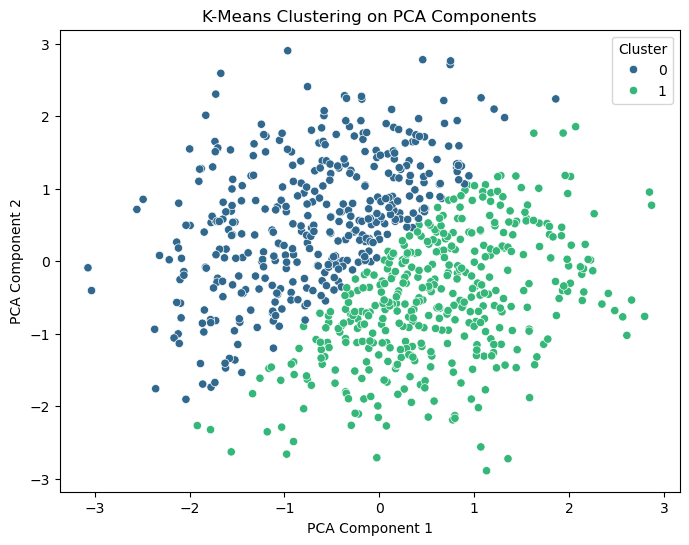

In [27]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Use 2 clusters for binary classification
clusters = kmeans.fit_predict(X_pca)

# Visualize K-Means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='viridis')
plt.title("K-Means Clustering on PCA Components")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

Component 1: Explained Variance Ratio = 0.1127, Cumulative = 0.1127
Component 2: Explained Variance Ratio = 0.1101, Cumulative = 0.2228
Component 3: Explained Variance Ratio = 0.1087, Cumulative = 0.3314
Component 4: Explained Variance Ratio = 0.1066, Cumulative = 0.4380
Component 5: Explained Variance Ratio = 0.1033, Cumulative = 0.5413
Component 6: Explained Variance Ratio = 0.0988, Cumulative = 0.6401
Component 7: Explained Variance Ratio = 0.0951, Cumulative = 0.7352
Component 8: Explained Variance Ratio = 0.0908, Cumulative = 0.8260
Component 9: Explained Variance Ratio = 0.0881, Cumulative = 0.9140
Component 10: Explained Variance Ratio = 0.0860, Cumulative = 1.0000


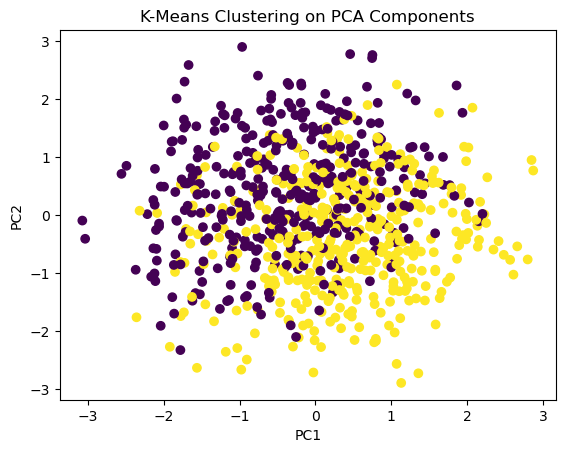

In [35]:
# Transform the data
X_train_pca = pca.transform(X_train[numerical_features])
X_test_pca = pca.transform(X_test[numerical_features])

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Print explained variance
for i, (var_ratio, cum_var) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance), 1):
    print(f"Component {i}: Explained Variance Ratio = {var_ratio:.4f}, Cumulative = {cum_var:.4f}")

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_train_pca)

# Visualize clusters (using the first two components for visualization)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis')
plt.title("K-Means Clustering on PCA Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### **3. Classification of materials**
Implement a MLP classifier on the data and estimate the accuracies, F-1 score and confusion matrix. Also carry out 5 fold stratified cross validation(read and explain this) and report the mean F1 score. (20)

### MLP Classifier

Accuracy: 0.6750
F1 Score: 0.7670
Confusion Matrix:
[[ 28  38]
 [ 27 107]]


/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


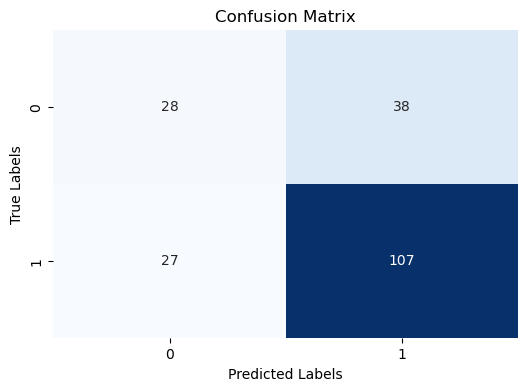


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.42      0.46        66
           1       0.74      0.80      0.77       134

    accuracy                           0.68       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.66      0.68      0.67       200



/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



F1 Scores for 5-Fold Stratified Cross-Validation:
[0.74336283 0.77391304 0.760181   0.81702128 0.7706422 ]
Mean F1 Score: 0.7730


/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [41]:
# Step 3.1: Implement MLP Classifier
# Initialize the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train the model on the PCA-transformed training data
mlp.fit(X_train_pca, y_train)

# Step 3.2: Evaluate the Model
# Predict on the test set
y_pred = mlp.predict(X_test_pca)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 3.3: Perform 5-Fold Stratified Cross-Validation
# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and calculate F1 scores
f1_scores = cross_val_score(mlp, X_train_pca, y_train, cv=stratified_kfold, scoring='f1')

# Print the F1 scores for each fold and the mean F1 score
print("\nF1 Scores for 5-Fold Stratified Cross-Validation:")
print(f1_scores)
print(f"Mean F1 Score: {f1_scores.mean():.4f}")

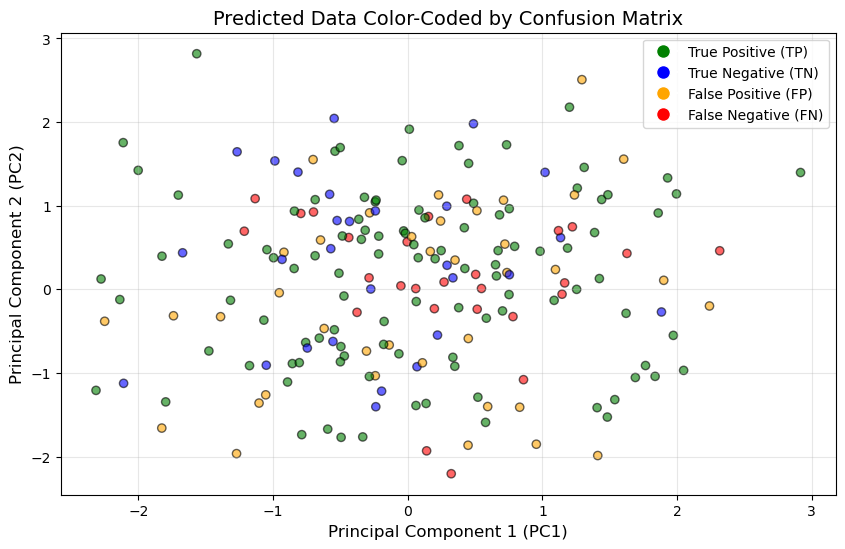

In [43]:
# Create an array to store the color for each point
colors = np.empty(len(y_test), dtype=object)  # Use dtype=object to store strings

# Assign colors based on the confusion matrix
for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)):
    if true_label == 1 and pred_label == 1:  # True Positive (TP)
        colors[i] = 'green'  # Correctly predicted as positive
    elif true_label == 0 and pred_label == 0:  # True Negative (TN)
        colors[i] = 'blue'  # Correctly predicted as negative
    elif true_label == 0 and pred_label == 1:  # False Positive (FP)
        colors[i] = 'orange'  # Incorrectly predicted as positive
    elif true_label == 1 and pred_label == 0:  # False Negative (FN)
        colors[i] = 'red'  # Incorrectly predicted as negative

# Step 2: Plot the PCA-transformed data with color coding
plt.figure(figsize=(10, 6))

# Scatter plot of the first two PCA components
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=colors, alpha=0.6, edgecolor='k')

# Add labels and title
plt.title("Predicted Data Color-Coded by Confusion Matrix", fontsize=14)
plt.xlabel("Principal Component 1 (PC1)", fontsize=12)
plt.ylabel("Principal Component 2 (PC2)", fontsize=12)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='True Positive (TP)', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='True Negative (TN)', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Positive (FP)', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='False Negative (FN)', markerfacecolor='red', markersize=10)
]
plt.legend(handles=legend_elements, loc='best')

# Show the plot
plt.grid(alpha=0.3)
plt.show()

### **4. Hyper-parameter tuning**
Implement hyperparameter tuning with 3fold cross validation on hidden layer sizes (includes both number of hidden layers and neurons), activation function, alpha (regularization) and the learning rate. Report the best performing model and the respective hyperparameters with highest accuracy. Retrain with the best model and report the F1 score on the test set.  (20)

In [48]:
# Step 4.1: Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Number of layers and neurons
    'activation': ['relu', 'tanh', 'logistic'],  # Activation function
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1]  # Initial learning rate
}

# Step 4.2: Perform Grid Search with 3-fold cross-validation
mlp = MLPClassifier(max_iter=500, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='f1', n_jobs=-1)  # Use F1 score for evaluation
grid_search.fit(X_train_pca, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Step 4.3: Retrain and evaluate the best model
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test_pca)

# Calculate F1 score on the test set
f1 = f1_score(y_test, y_pred)
print(f"F1 Score on Test Set: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.1

Best Hyperparameters:
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
F1 Score on Test Set: 0.7517
Confusion Matrix:
[[ 14  52]
 [ 22 112]]

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.21      0.27        66
           1       0.68      0.84      0.75       134

    accuracy                           0.63       200
   macro avg       0.54      0.52      0.51       200
weighted avg       0.59      0.63      0.59       200



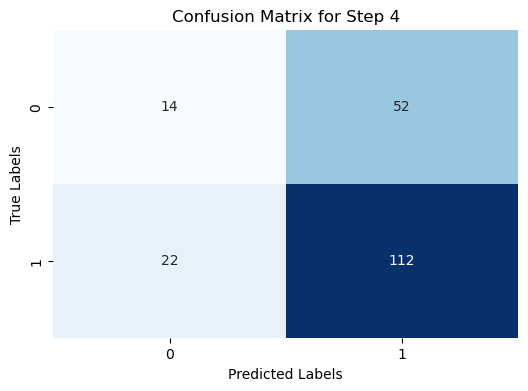

In [50]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Step 4")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

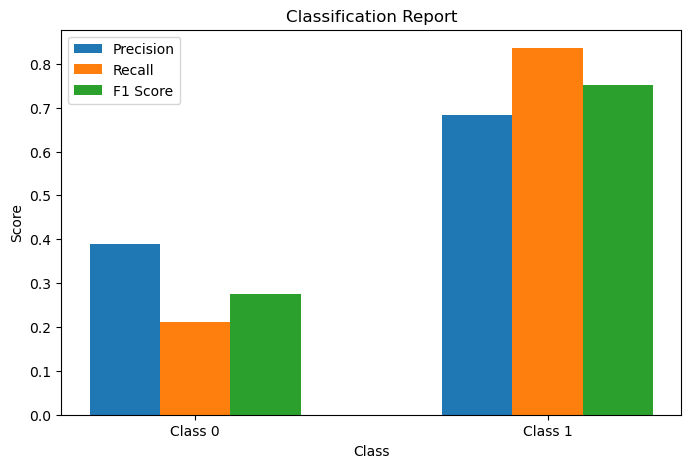

In [51]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
labels = ['Class 0', 'Class 1']  # Replace with your class labels

# Plot the metrics
plt.figure(figsize=(8, 5))
x = np.arange(len(labels))
width = 0.2

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')

plt.title("Classification Report")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(x, labels)
plt.legend()
plt.show()

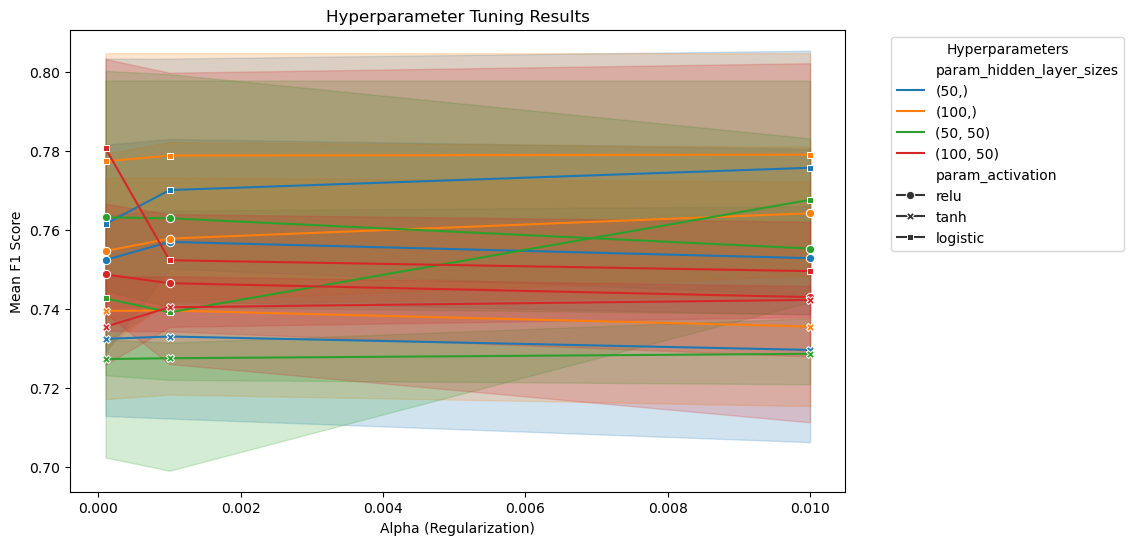

In [52]:
# Convert the grid search results to a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot the performance of different hyperparameter combinations
plt.figure(figsize=(10, 6))
sns.lineplot(data=results, x='param_alpha', y='mean_test_score', hue='param_hidden_layer_sizes', style='param_activation', markers=True, dashes=False)
plt.title("Hyperparameter Tuning Results")
plt.xlabel("Alpha (Regularization)")
plt.ylabel("Mean F1 Score")
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tatas/miniconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


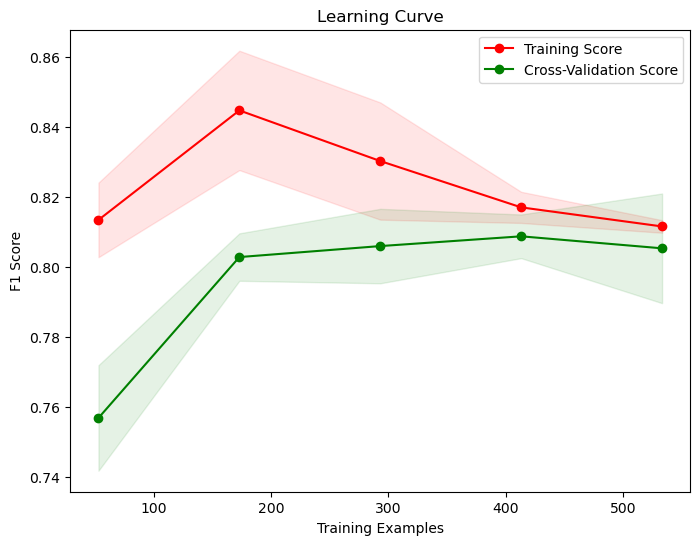

In [55]:
# Get the learning curve data
train_sizes, train_scores, test_scores = learning_curve(best_mlp, X_train_pca, y_train, cv=3, scoring='f1', n_jobs=-1)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

### **5. Neural Networks using Tensorlow**
In the era of generative AI, which is powered by neural networks, many architectures are becoming available to achieve higher accuracy. Implement a neural network in tensorflow using an architecture of your choice (describe the choice). Report the resulting accuracy and F1 score you get on the test set. (20)

### **Cool things you can try doing if you want that won't be graded** <br>
1. Remove outliers to see if that improves the classification
2. Try out data visualization techniques that were not covered in the course
3. Implement feature selection and then try out MLP
4. See if you can implement transfer learning and hyperparameter tuning for your neural network model